In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import *
from sklearn.ensemble import *
%matplotlib inline

# Session 4

In this session, we will look at another regression problem, but this time with time series data.

One of the most striking features of time series data is that observations are often highly correlated, predictors as well as the response. Since this correlation is embedded in the series itself, we speak of *serial correlation*. As we will see in this session, serial correlation can be exploited for feature engineering, but it also effects the way in which we can do cross-validation.

1. If the response is correlated over time, previous responses that are available at the time when we want to make a prediction carry information about future responses, whichs means that we can use *lagged* responses as features. Many time series models in statistics, such as autoregressive models, in fact use only lagged responses as features.

2. When observations are correlated, we must be careful with how we do cross validation. If we separate our data randomly into a train and a test set, it is very likely that successive observations end up in train and test set separately. If there is strong serial correlation, the effect is nearly the same as if we used our train set as test set. This may not be a problem for weak earners, but may destroy the quality if the learner is very strong as we will see below.

### Cross Validation for Time Series

If we want to learn something about the quality of our time series predictor, we should try to mimick the way in which we use the predictor in reality. The best approach is to separate the data into past and future data, and then use past data to predict the future. If we do not use all future data to test our predictor, we can even do this by using a moving time window.

1. Forecast horizon $h$, number of validations $k$, $i=0$
2. Set $i \gets i+1$
3. Fit model to data $1,\dots,T-k-h+i$
4. Compute forecast for $T-k-h+i+1$ and record error
5. If $i< k$ go to step 2
6. Return the average error

We should keep in mind that the errors themselves are also serially correlated, unless we leap the time window forward until the serial correlation disappears.

## Particulate Matter Pollution in Beijing

The data set that we will use for our model has been collected by [Manuel Riel](http://blog.snapdragon.cc/author/manu/) in 2014. The data aggregates hourly measurements from dozens of weather stations across Beijing as well as exogenous weather data from a data service for those locations, like ozone, wind direction, humidity, wind speed, temerpature, air pressure and day length.

Let us begin by importing this data into a Pandas DataFrame.

In [15]:
url = 'https://raw.githubusercontent.com/loehndorf/dmds/master/data/pm_25_weather.csv'
data = pd.read_csv(url, index_col=0, infer_datetime_format=True)
data.head()

,pm2_5,o3,wdird,hum,wspdm,tempm,pressurem,sunhours
datetime,,,,,,,,
15-08-2014 00:00,21.416667,24.416667,80,78,7.2,21,1006,13.775067
15-08-2014 01:00,24.333333,22.416667,0,88,0.0,20,1006,13.775067
15-08-2014 02:00,27.416667,20.083333,290,77,3.6,21,1006,13.775067
15-08-2014 03:00,28.750000,22.250000,350,88,7.2,19,1006,13.775067
15-08-2014 04:00,24.333333,24.500000,0,94,3.6,18,1006,13.775067


If we plot the response over time, it is easy to see that it exhibits a fair degree of serial correlation.

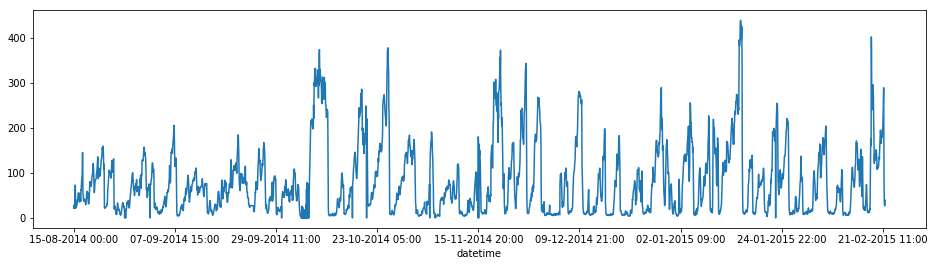

In [16]:
data.pm2_5.plot(figsize=(16,4))

### Cross Validation
Let us now prepare the data for cross validation by separating it into past and future data. In our case, we simply exclude the last four weeks of data.

In [18]:
X_h = data.drop('pm2_5', axis=1).iloc[:-4*168]
y_h = data.pm2_5.iloc[:-4*168]
X_f = data.drop('pm2_5', axis=1).iloc[-4*168:]
y_f = data.pm2_5.iloc[-4*168:]

Additionally let us create a random shuffle split of the data.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_h, y_h, random_state=7)

## Decision Tree

One of the strongest learners in data mining, yet also one of the most intuitive, is the decision tree. A decision tree successively partitions the data into non-overlapping subsets along those features that reduce the prediction error in each partition the most. The resulting tree provides a set of splitting rules which can then be used as guidance to decide into which partition new observations are being assigned. The average in this partition is then used as predictor for the new observation.

### A simple tree building algorithm

Input: A set of training records $R_j = (X_i,y_i)_{i=1}^N$ with $j$ being the index of the node of the tree.

Step 1. Repeat until no further splits are possible <br>
Step 1.1. If all records in $R_j$ have identical $y_i$ then $j$ is a leaf node. <br>
Step 1.2. Else split the set $R_j$ into two subsets, $R_{j+1}$ and $R_{j+2}$, such that the information gain is maximized. <br>
Step 2. Prune the tree, e.g., by setting a maximum depth, until the test error is minimal

Output: Use the average (regression) or the majority vote (classification) within each subset for prediction

Let us create a basic decision tree for regression and train the learner with the training set from our shuffle split.

In [21]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_train,y_train),reg.score(X_test,y_test)

(1.0, 0.79069260289493848)

Unlike with other learners the decision tree provides a perfect fit for the training sample with zero bias, unless the tree gets pruned. Let us try to find the depth that minimizes the cross-validation error.

In [22]:
reg = DecisionTreeRegressor(max_depth=10)
reg.fit(X_train, y_train)
reg.score(X_test,y_test)

0.81406505494768511

Since we are dealing with a time series and used a shuffle split, our test and training set are highly correlated. Let us therefore compare the cross-validation error from our test set with the future data set.

In [23]:
reg.score(X_test,y_test),reg.score(X_f,y_f)

(0.81406505494768511, 0.045523322717686221)

As we can see, the difference between the two cross-validation errors is substantial, which shows that we cannot rely on shuffle splitting for time series cross valdiation. Let us end this with plotting the difference between the future data and its forecast.

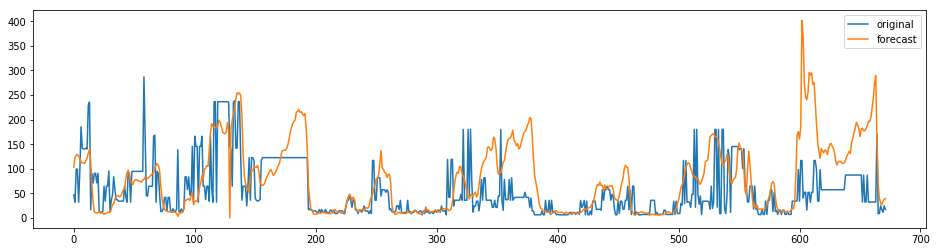

In [24]:
pd.DataFrame([reg.predict(X_f),y_f],index=['original','forecast']).transpose().plot(figsize=(16,4))

## Random Forest

A popular solution to the problem overfitting in decision trees is to learn multiple trees for different variants of the same sample and average their predictions. This approach is also referred to as *bagging* which is a type of *ensemble* method, since multiple predictions are aggregated into a single prediction.

One of the most successul ensemble methods in data mining is the *random forest*. Each tree in a random forest is trained on a bootstrap sample. Since predictions can still be correlated, instead of using all features as splitting candidates, only a random subset of features is used as splitting candidates. This leads to a set of very different trees as predictors.

## Random Forest

Input: A set of training records $R_j = (X_i,y_i)_{i=1}^N$

1. Set b=1
2. Generate a new set of training records, $R_b$, by bootstrapping the training records
3. Learn a decision tree $f_b$ on $R_b$ that **randomly selects $\sqrt{p}$ features at each split**.
4. If b<B go to step 2

Output: For a given test record $X$, return the average prediction:

$$f(X) = \frac{1}{M} \sum_{b=1}^B f_b(X) $$

A nice side effect of using a bootstrap sample to learn a tree is that not all observations are included in the sample and can be used for cross validation. In fact, each tree is trained with on average 2/3 of the original observations. We can use the remainder to compute a so-called out-of-bag (OOB) score.

### Out-of-Bag Score

1. Set b=1
2. Generate a new set of training records, $R_b$, by bootstrapping the training records.
3. Store the indices of the remainder set $Q_b = \{k \ | \ R_{k} \notin R_b, k=1,\dots,N \}$.
4. Learn a decision tree $f_b$ on $R_b$.
5. Store the out-of-bag error.
$$OOB_b = \sum_{k \in Q_b} (f_b(X_k)-y_k)^2$$
6. If $b<B$ go to step 2

$$\text{OOB Score} = 1- \frac{\sum_{b=1}^B OOB_b}{\bar{y}}$$



Let us use scikit-learn's ensemble package to create a random forest regressor with 100 trees and have it compute the OOB score.

In [25]:
reg = RandomForestRegressor(n_estimators=100, oob_score=True)
reg.fit(X_train, y_train)
reg.score(X_test,y_test), reg.oob_score_

(0.89265311047484552, 0.87572260147700054)

The result of the fit is much better as with the single decision tree, irrespective of pruning. We can also see that the OOB score is a good proxy for the cross-validation error from shuffle splitting. Nevertheless,  bootstrapping has the same effect as shuffle splitting, out-of-bag observations will be correlated with observations from the bootstrap sample, so that our cross-validation error is hopelessly biased, and the forecasting quality of the random forest regressor is not much better than that of the decision tree regressor.

In [26]:
reg.score(X_test,y_test),reg.score(X_f,y_f)

(0.89265311047484552, 0.15370120552460498)

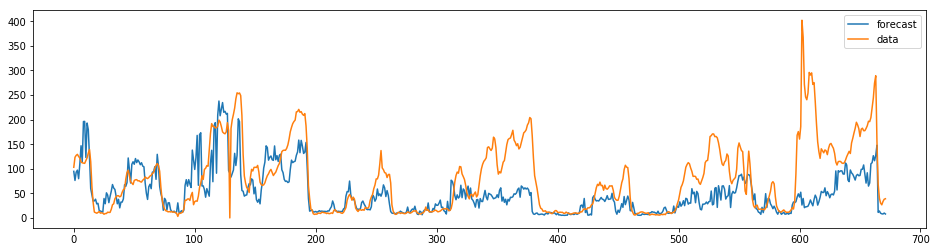

In [27]:
pd.DataFrame([reg.predict(X_f),y_f],index=['forecast','data']).transpose().plot(figsize=(16,4))

## Homework

Names: (put your names here)

### Exercise 1

Implement a function for time series cross-validation with a moving time window and use it to compute the $R^2$ of a DecisionTreeRegressor.

### Exercise 2
Compare the cross validated $R^2$ of a RandomForestRegressor with the OOB score? Explain the deviation between both figures.